In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import prophet
import warnings
warnings.filterwarnings("ignore")

In [6]:
data = pd.read_excel(
    "../../data/covid-indo/raw/Daily Update Data Agregat Covid-19 Jakarta.xlsx", sheet_name="Data Jakarta")
positif_harian = data[["Tanggal", "Positif Harian"]]
positif_harian["Tanggal"] = pd.to_datetime(positif_harian["Tanggal"])
# positif_harian.set_index("Tanggal", inplace=True)
positif_harian.head()

,Tanggal,Positif Harian
0,2020-03-01,0
1,2020-03-02,0
2,2020-03-03,3
3,2020-03-04,0
4,2020-03-05,4


In [8]:
positif_harian_cp = positif_harian.copy()
positif_harian_cp.columns = ["ds", "y"] 

In [9]:
model = prophet.Prophet()
model.fit(positif_harian_cp)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-01,210.706710,-1216.854825,3310.930223,210.706710,210.706710,890.669100,890.669100,890.669100,80.034644,80.034644,80.034644,810.634456,810.634456,810.634456,0.0,0.0,0.0,1101.375810
1,2020-03-02,214.352861,-1520.246549,2847.046863,214.352861,214.352861,490.913920,490.913920,490.913920,-116.212214,-116.212214,-116.212214,607.126134,607.126134,607.126134,0.0,0.0,0.0,705.266782
2,2020-03-03,217.999013,-1466.289220,2535.732601,217.999013,217.999013,178.253330,178.253330,178.253330,-247.720875,-247.720875,-247.720875,425.974205,425.974205,425.974205,0.0,0.0,0.0,396.252342
3,2020-03-04,221.645164,-1546.738547,2699.103881,221.645164,221.645164,284.546520,284.546520,284.546520,16.974996,16.974996,16.974996,267.571524,267.571524,267.571524,0.0,0.0,0.0,506.191684
4,2020-03-05,225.291315,-1868.128701,2617.518660,225.291315,225.291315,199.784708,199.784708,199.784708,67.982618,67.982618,67.982618,131.802091,131.802091,131.802091,0.0,0.0,0.0,425.076024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,2023-06-18,452.951195,-1854.414688,2741.975653,-22.436675,925.632935,39.358832,39.358832,39.358832,80.034644,80.034644,80.034644,-40.675812,-40.675812,-40.675812,0.0,0.0,0.0,492.310027
1205,2023-06-19,450.078915,-1644.535459,2694.508447,-27.814175,924.192375,45.908533,45.908533,45.908533,-116.212214,-116.212214,-116.212214,162.120746,162.120746,162.120746,0.0,0.0,0.0,495.987447
1206,2023-06-20,447.206635,-1540.333108,2916.245267,-33.191676,922.751814,135.732473,135.732473,135.732473,-247.720875,-247.720875,-247.720875,383.453348,383.453348,383.453348,0.0,0.0,0.0,582.939108
1207,2023-06-21,444.334355,-1105.206266,3222.476914,-38.569176,921.311254,638.752199,638.752199,638.752199,16.974996,16.974996,16.974996,621.777203,621.777203,621.777203,0.0,0.0,0.0,1083.086553


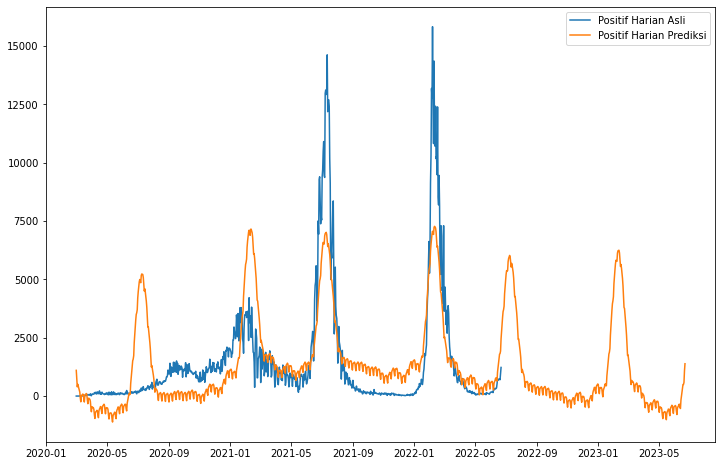

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(positif_harian["Tanggal"], positif_harian["Positif Harian"], label="Positif Harian Asli")
plt.plot(forecast["ds"], forecast["yhat"], label="Positif Harian Prediksi")
plt.legend()
plt.show()

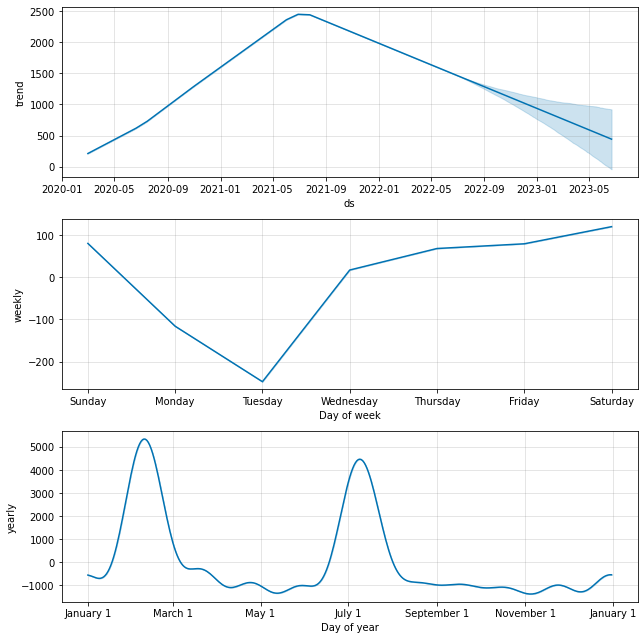

In [23]:
fig = model.plot_components(forecast)

In [25]:
prophet.plot.plot_plotly(model, forecast)

## Hyperparameter Tuning

In [30]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools

positif_harian_new = positif_harian.copy()
positif_harian_new.columns = ["ds", "y"]
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v))
              for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit model with given params
    m = prophet.Prophet(**params).fit(positif_harian_new)
    df_cv = cross_validation(
        m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01  3303.993764
1                     0.001                     0.10  3232.194988
2                     0.001                     1.00  3225.483670
3                     0.001                    10.00  3236.322201
4                     0.010                     0.01  3510.058930
5                     0.010                     0.10  3428.205509
6                     0.010                     1.00  3416.896204
7                     0.010                    10.00  3428.672652
8                     0.100                     0.01  4268.208625
9                     0.100                     0.10  4456.938813
10                    0.100                     1.00  4517.193446
11                    0.100                    10.00  4504.466765
12                    0.500                     0.01  3824.252138
13                    0.500                     0.10  4360.942913
14        

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


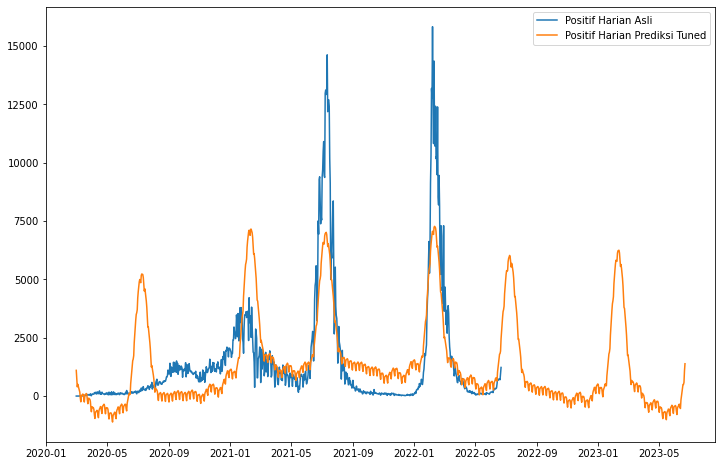

In [32]:
positif_harian_tuned = positif_harian.copy()
positif_harian_tuned.columns = ["ds", "y"]

model_tuned = prophet.Prophet(
    changepoint_prior_scale=0.001, seasonality_prior_scale=0.1).fit(positif_harian_tuned)

future = model.make_future_dataframe(periods=365)
forecast_tuned = model.predict(future)

plt.figure(figsize=(12, 8))
plt.plot(positif_harian["Tanggal"],
         positif_harian["Positif Harian"], label="Positif Harian Asli")
plt.plot(forecast_tuned["ds"], forecast_tuned["yhat"],
         label="Positif Harian Prediksi Tuned")
plt.legend()
plt.show()